In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

plt.style.use('tableau-colorblind10')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

%load_ext autoreload
%autoreload 2

In [191]:
def cross_corr(
        exemplar_emb: torch.Tensor,
        instance_emb: torch.Tensor) -> torch.Tensor:
    assert exemplar_emb.ndim == instance_emb.ndim
    assert exemplar_emb.ndim == 4

    n_instances, instance_c, instance_h, instance_w = instance_emb.shape

    instance_emb = instance_emb.reshape(1, -1, instance_h, instance_w)
    response_map = F.conv2d(
        input=instance_emb, weight=exemplar_emb, groups=n_instances)
    response_map = response_map.reshape(
        n_instances, -1, response_map.shape[-2], response_map.shape[-1])

    return response_map

s = 18
loss_grid = np.zeros((s, s))

for r in range(0, s):
    for c in range(0, s):
        exemplar_size = 5
        instance_size = 22
        exemplar_emb = np.ones((exemplar_size, exemplar_size, 1))
        instance_emb = np.zeros((instance_size, instance_size, 1))
        exemplar_row, exemplar_col = r, c
        instance_emb[
            exemplar_row:exemplar_row + exemplar_size,
            exemplar_col:exemplar_col + exemplar_size, 0] = 1

        # plt.imshow(instance_emb, cmap='binary')
        # plt.show()

        # def to_tensor(arr):
        #     return torch.from_numpy(np.transpose(arr, axes=(2, 0, 1))[None, ...])
        #
        # exemplar_emb = to_tensor(exemplar_emb)
        # instance_emb = to_tensor(instance_emb)

        # response = cross_corr(exemplar_emb, instance_emb)
        # response = response.cpu().detach().numpy()
        # response = np.transpose(np.squeeze(response, axis=0), axes=(1, 2, 0))
        #
        # print(np.unravel_index(response.argmax(), response.shape))
        #
        # plt.imshow(response, cmap='binary')
        # plt.show()

        def to_tensor(arr):
            return torch.from_numpy(
                np.transpose(arr, axes=(2, 0, 1))[None, ...])

        exemplar_emb = to_tensor(exemplar_emb)
        instance_emb = to_tensor(instance_emb)

        response = cross_corr(exemplar_emb, instance_emb)

        from sot.losses import WeightedBCELoss
        from sot.utils import create_ground_truth_mask_and_weight

        mask_mat, weight_mat = create_ground_truth_mask_and_weight(
            (s, s), 16, 8, 1)

        mask_mat = torch.from_numpy(mask_mat)
        weight_mat = torch.from_numpy(weight_mat)

        criterion = WeightedBCELoss(weight_mat)
        loss = criterion(response, mask_mat)
        loss_grid[r, c] = loss.item()


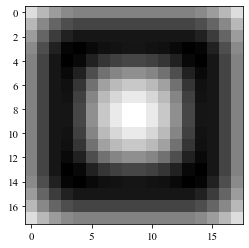

In [192]:
mask = np.squeeze(mask_mat.numpy())
plt.imshow(loss_grid, cmap='binary')
plt.show()